makemore: multilayer perceptron
===
# part 1 & 2


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi.update({'.': 0})
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
def build_dataset(name_list):
    '''
    Dataset consists of input tensor X and label tensor Y. 
    Input tensor contains three numerically encoded characters (independent of the name it originates from).
    Label tensor carries the respective following character (also encoded).
    '''
    block_size = 3
    X, Y = [], []
    for name in name_list:
        context = [0] * block_size
        for ch in name + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(12219195)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [5]:
g = torch.Generator().manual_seed(12219195)

hidden_dim = 200
emb_dim = 10
block_size = 3

C = torch.randn((27,emb_dim)                        ,generator=g)
W1 = torch.randn((emb_dim*block_size,hidden_dim)    ,generator=g) * (5/3)/(emb_dim*block_size)**0.5 #* 0.2
b1 = torch.randn(hidden_dim                         ,generator=g) * 0.1 # actually useless 
W2 = torch.randn((hidden_dim,27)                    ,generator=g) * 0.1
b2 = torch.randn(27                                 ,generator=g) * 0.1

# parameters of batch normalization
bngain = torch.ones((1, hidden_dim)) * 0.1 + 1.0
bnbias = torch.zeros((1, hidden_dim)) * 0.1
# buffers of batch normalization (not trained with backprop)
bnmean_running = torch.zeros((1, hidden_dim))
bnstd_running = torch.ones((1, hidden_dim))

parameters = [C, W1, b1, W2, b2, bngain, bnbias] # b1
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12297


In [104]:
n_steps = 20000
batch_size = 32
lossi = []

for i in range(n_steps):
    # minibatch contruct
    batch_ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[batch_ix], Ytr[batch_ix]

    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(Xb.shape[0],-1) # concatenate vectors
    # linear layer
    hpreact = embcat @ W1 # + b1    # no bias because it will be subtraced out in the batch norm anyway
    # batch norm layer
    # ----------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ----------------------------------------------------------
    # activation function 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[batch_ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 50000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: 
        print(f'{i:7d}/{n_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
print(loss.item())

      0/  20000: 3.2860
  10000/  20000: 2.2477
2.2910122871398926


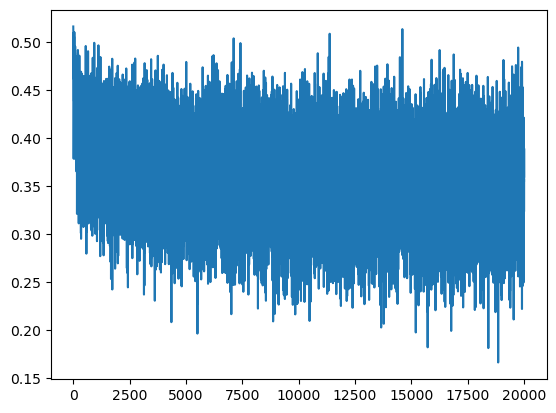

In [94]:
plt.plot(lossi);

In [95]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [96]:
@torch.no_grad()
def split_loss(split):
    x,y = { 'train': (Xtr, Ytr),
            'val': (Xdev, Ydev),
            'test': (Xte, Yte)}[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2122364044189453
val 2.2394468784332275


In [97]:
g = torch.Generator().manual_seed(12219195)

for _ in range(20):
    word = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1) # + b1
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() # torch.max(probs, dim=1)  
        context = context[1:] + [ix]
        word.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in word))


maivirdom.
mmmttavishavedhannahastefakhunbyrdna.
hashustlybaansrigh.
huusafutkllinaerryg.
khramshammakyuxausnacrzengheytonivckenghlynn.
hudvymahlyndedrotifannafjundyhshaflahjr.
dshabrixfoesten.
madshkydsefondonsen.
brilghannlrennabruz.
vannasren.
shiflenn.
havlevdalinahdon.
maklyn.
destinnlyck.
bria.
khamda.
matdan.
flemman.
rhzavyonxshermanthkinzlemakahlyn.
murgh.


In [66]:
names = ['luise']
for n in names:
    context = block_size * [0]
    likey = 1
    for ch in n + '.':
        ix = stoi[ch]
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1) # + b1
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        print(''.join([itos[i] for i in context]), '--->', ch, '\t', prob[0,ix].item())
        likey *= prob[0,ix]
        context = context[1:] + [ix]
    print(likey.item())


... ---> l 	 0.013624904677271843
..l ---> u 	 0.446750670671463
.lu ---> i 	 0.002670345129445195
lui ---> s 	 0.19389955699443817
uis ---> e 	 0.04016263782978058
ise ---> . 	 0.11721941083669662
1.4837633344200185e-08
